# Objective of this Notebook

## Extract Features of Strategy in Random0: Forced Coordination Case


1. One pot fill or both simultaneously? Overlap in cooking time between pots. 
2. Utilization of counter space. Which objects are passed over which counters? Use of more than 1 counter? How is it distributed over other counters? Is it consistent in which object?
3. Number of premature dishes brought
4. Consistency of strategy, Does strategy change when something better comes up?


## Import Dependencies

In [1]:
# %matplotlib inline
# %matplotlib notebook
import tqdm, copy
import random, os
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from collections import defaultdict
from overcooked_ai_py.utils import save_pickle
from human_aware_rl.utils import set_global_seed
from human_aware_rl.human.process_dataframes import *
from human_aware_rl.static import *
import pickle as pkl

set_global_seed(1884)

In [2]:
import ast
import json

from scipy import stats


# Define Helper Functions

In [3]:
def json_eval(s):
    json_acceptable_string = s.replace("'", "\"")
    d = json.loads(json_acceptable_string)
    return d

In [4]:

def plot_trial(trial_id, p1_data, p2_data, objects_data, name, title):
        
    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)
    
    
    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            # Floor = gray
            grid_display[i,j,:] = [220,220,220]
            if layout[i,j] == 'X':
                # Counter = Tan
                grid_display[i,j,:] = [91,153,91]
            if layout[i,j] == 'P':
                # Pots = brown
                grid_display[i,j,:] = [139,69,19]
            if layout[i,j] == 'S':
                # Serve = Green
                grid_display[i,j,:] = [34,139,34]
            if layout[i,j] == 'O':
                # Onion = Yellow
                grid_display[i,j,:] = [218,165,32]
            if layout[i,j] == 'D':
                # Dishes = Blue
                grid_display[i,j,:] = [65,105,225]
            if layout[i,j] == 'T':
                # Tomato = Blue
                grid_display[i,j,:] = [255,69,0]


    # loop over your images
    for a in range(len(t)):

        fig = plt.figure(figsize=(8,3))

        sin_ax = plt.axes([0.1, 0.2, 0.8, 0.65])

        plt.axes(sin_ax) # select sin_ax

        plt.imshow(grid_display.astype(np.uint8), vmin=0, vmax=255)


        scat1 = plt.scatter(f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1], lw=20, c='r')
        line1, = plt.plot(f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1], lw=5, c='r')

        arrow1 = plt.arrow(arrow_p1(t, a, p1_data)[0], arrow_p1(t, a, p1_data)[1], 
                           arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3], head_width=0.5,
                           head_length=0.5, width=0.02, fc='r', ec='r', length_includes_head=True)

        if obj_p1(t, a, p1_data)[0] is not None:
            arrow_obj1 = plt.scatter(obj_p1(t, a, p1_data)[0], obj_p1(t, a, p1_data)[1], 
                                     lw=10, c=obj_p1(t, a, p1_data)[3])


        scat2 = plt.scatter(f_p2(t, a, p2_data)[0], f_p2(t, a, p2_data)[1], lw=20, c='b')
        line2, = plt.plot(f_p2(t, a, p2_data)[0], f_p2(t, a, p2_data)[1], lw=5, c='b')

        arrow2 = plt.arrow(arrow_p2(t, a, p2_data)[0], arrow_p2(t, a, p2_data)[1], 
                           arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3], head_width=0.5,
                           head_length=0.5, width=0.02, fc='b', ec='b', length_includes_head=True)

        if obj_p2(t, a, p2_data)[0] is not None:
            arrow_obj2 = plt.scatter(obj_p2(t, a, p2_data)[0], obj_p2(t, a, p2_data)[1], 
                                     lw=10, c=obj_p2(t, a, p2_data)[3])

        objects_list = world_obj(t, a, objects_data)
        for obj in objects_list:
            obj_add = plt.scatter(obj[0], obj[1], 
                                     lw=10, c=obj[2])

        trial_name = name + '_'+str(trial_id)
        if not os.path.exists(trial_name):
            os.makedirs(trial_name)

        plt.savefig(trial_name+'/im_'+str(a)+'.png')
        plt.close()


In [5]:

def f_p1(t, a, p1_data):
    t_partial = t[int(a)-1:int(a)]
#     print('t_input', t)
    return [p1_data[int(j)]['position'][0] for j in t_partial], [p1_data[int(j)]['position'][1] for j in t_partial]
def f_p2(t, a, p2_data):
    t_partial = t[int(a)-1:int(a)]
    return [p2_data[int(j)]['position'][0] for j in t_partial], [p2_data[int(j)]['position'][1] for j in t_partial]



def arrow_p1(t, a, p1_data):
#     t_partial = t[int(a)-1:int(a)+1]
#     print('t_input', t)
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1],\
            p1_data[int(a)]['orientation'][0], p1_data[int(a)]['orientation'][1]
def arrow_p2(t, a, p2_data):
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1],\
            p2_data[int(a)]['orientation'][0], p2_data[int(a)]['orientation'][1]


def held_p1(t, a, p1_data):
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1],\
            p1_data[int(a)]['orientation'][0], p1_data[int(a)]['orientation'][1]
def held_p2(t, a, p2_data):
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1],\
            p2_data[int(a)]['orientation'][0], p2_data[int(a)]['orientation'][1]


def world_obj(t, a, objects_data):
    obj_world = objects_data[int(a)]
    if len(obj_world)==0:
        return []
    objects_list = []
    for i in range(len(obj_world)):
        obj = obj_world[i]
        name = obj_world[i]['name']
        position = obj_world[i]['position']
        if name == 'onion':
            color = 'y'
            objects_list.append((position[0], position[1], name, color))
        if name == 'dish':
            color = 'k'
            objects_list.append((position[0], position[1], name, color))
        if name == 'soup':
            if obj['is_cooking'] is True:
                color = 'r'
            elif obj['is_ready'] is True:
                color = 'g'
            else:
                color = 'orange'
            objects_list.append((position[0], position[1], name, color))
        
    return objects_list


def obj_p1(t, a, p1_data):
#     t_partial = t[int(a)-1:int(a)+1]
#     print('t_input', t)
    color = 'k'
    if p1_data[int(a)]['held_object'] is None:
        return [None, None, None, None]
    else:
        name = p1_data[int(a)]['held_object']['name']
        if name == 'dish':
            color = 'k'
        elif name == 'onion':
            color = 'y'
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1], p1_data[int(a)]['held_object']['name'], color

def obj_p2(t, a, p2_data):
    color = 'k'
    if p2_data[int(a)]['held_object'] is None:
        return [None, None, None, None]
    else:
        name = p2_data[int(a)]['held_object']['name']
        if name == 'dish':
            color = 'k'
        elif name == 'onion':
            color = 'y'
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1], p2_data[int(a)]['held_object']['name'], color


# [{'name': 'soup',
#    'position': [4, 1],
#    '_ingredients': [{'name': 'onion', 'position': [4, 1]},
#     {'name': 'onion', 'position': [4, 1]}],
#    'cooking_tick': -1,
#    'is_cooking': False,
#    'is_ready': False,
#    'is_idle': True,
#    'cook_time': -1,
#    '_cooking_tick': -1}],

NORTH = (0, -1)
SOUTH = (0, 1)
EAST  = (1, 0)
WEST  = (-1, 0)
STAY = (0,0)
INTERACT = 'INTERACT'
# STAY = [0,0]

def action_p1(t, a, p1_data):
    if p1_data[int(a)] == 'INTERACT':
        act = 'I'
    else:
        x, y = p1_data[int(a)][0], p1_data[int(a)][1]
        act = 'N'
        if (x,y) == NORTH:
            act = 'N'
        if (x,y) == SOUTH:
            act = 'S'
        if (x,y) == EAST:
            act = 'E'
        if (x,y) == WEST:
            act = 'W'
        if (x,y) == STAY:
            act = 'Y'
        
    return act

def action_p2(t, a, p2_data):
    if p2_data[int(a)] == 'INTERACT':
        act = 'I'
    else:
        x, y = p2_data[int(a)][0], p2_data[int(a)][1]
        act = 'N'
        if (x,y) == NORTH:
            act = 'N'
        if (x,y) == SOUTH:
            act = 'S'
        if (x,y) == EAST:
            act = 'E'
        if (x,y) == WEST:
            act = 'W'
        if (x,y) == STAY:
            act = 'Y'
        
    return act





# Import Cleaned Data

In [6]:
hh_all_2020_file = '/Users/michellezhao/Documents/overcooked_research/human_aware_rl/human_aware_rl/static/human_data/cleaned/2020_hh_trials_all.pickle'
hh_all_2019_file = '/Users/michellezhao/Documents/overcooked_research/human_aware_rl/human_aware_rl/static/human_data/cleaned/2019_hh_trials_all.pickle'






In [7]:
with open(hh_all_2020_file,'rb') as file:
    humans_2020_file = pkl.load(file)
    
with open(hh_all_2019_file,'rb') as file:
    humans_2019_file = pkl.load(file)



In [8]:
humans_2020_file.to_csv('humans_all_2020.csv')

In [9]:
humans_2019_file.to_csv('humans_all_2019.csv')

In [10]:
humans_2020_file.columns

Index(['state', 'joint_action', 'reward', 'time_left', 'score', 'time_elapsed',
       'cur_gameloop', 'layout', 'layout_name', 'trial_id', 'player_0_id',
       'player_1_id', 'player_0_is_human', 'player_1_is_human',
       'cur_gameloop_total', 'score_total', 'button_press',
       'button_press_total', 'timesteps_since_interact',
       'button_presses_per_timstep'],
      dtype='object')

In [11]:
old_trials = humans_2019_file
new_trials = humans_2020_file

In [12]:
all_trials = pd.concat([old_trials, new_trials])

In [13]:
all_trials.columns

Index(['Unnamed: 0', 'cur_gameloop', 'joint_action', 'layout', 'layout_name',
       'reward', 'score', 'state', 'time_elapsed', 'time_left', 'trial_id',
       'player_0_is_human', 'player_1_is_human', 'player_0_id', 'player_1_id',
       'cur_gameloop_total', 'score_total', 'button_press',
       'button_press_total', 'timesteps_since_interact',
       'button_presses_per_timstep'],
      dtype='object')

In [14]:
len(all_trials['trial_id'].unique())

373

# 1. One pot fill or both simultaneously? Overlap in cooking time between pots. 

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
from ast import literal_eval

# Use Agg backend for canvas
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'
trial_data = {}

for j in range(len(layout_trials)):
# for j in [1]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
#         print('joint_actions', joint_actions)
        
        if state_x['players'][0]['position'][0] == 1:
            p1_index = 0
            p2_index = 1
        else:
            p1_index = 1
            p2_index = 0
        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
    break
        
#     trial_data[trial_id] = {}
#     trial_data[trial_id]['p1_length'] = len(p1_data)
#     trial_data[trial_id]['p2_length'] = len(p2_data)
    
#     trial_data[trial_id]['score'] = score
    
#     trial_data[trial_id]['passed_object_steps'] = compute_steps_per_object_transfer(p1_data, 
#                                                                                         p2_data,
#                                                                                        objects_data,
#                                                                                        p1_actions,
#                                                                                        p2_actions,
#                                                                                        name)

    

    

trial_id 9


In [39]:
def compute_cook_overlap(p1_data, p2_data, objects_data, p1_actions, p2_actions, name, time_elapsed):

    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)

    pot_cook_time = {'top': 0,'right': 0, 'overlap': 0}

    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

    # loop over your images
    for a in range(len(t)-1):
    # for a in range(100):

        p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
        p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
        p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                    obj_p1(t, a, p1_data)[1], \
                    obj_p1(t, a, p1_data)[2]
        p1_act = action_p1(t, a, p1_actions)

        p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
        p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
        p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                    obj_p2(t, a, p2_data)[1], \
                    obj_p2(t, a, p2_data)[2]
        p2_act = action_p2(t, a, p2_actions)
    #     objects_list = world_obj(t, a, objects_data)
        objects_list = objects_data[a]
        time_passed = time_elapsed[a+1] - time_elapsed[a]


        ################## POT OVERLAP ##################
    #     print('objects_list', objects_list)
        ## Pot locations = top(3,0) and right(4,1)
        cooking_top_bool = False
        cooking_right_bool = False
        for i in range(len(objects_list)):
            obj_i = objects_list[i]

            if obj_i['name'] == 'soup':
                if obj_i['is_cooking'] == True or obj_i['is_ready'] == True:
                    if obj_i['position'] == [4,1]:
                        cooking_right_bool = True
                        pot_cook_time['right'] += time_passed
                    else:
                        cooking_top_bool = True
                        pot_cook_time['top'] += time_passed

        if cooking_top_bool is True and cooking_right_bool is True:
            pot_cook_time['overlap'] += time_passed


    overlap_ratio = pot_cook_time['overlap']/(pot_cook_time['top']+pot_cook_time['right'])
    return overlap_ratio



In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
from ast import literal_eval

# Use Agg backend for canvas
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'
trial_data = {}

for j in range(len(layout_trials)):
# for j in [1]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
#         print('joint_actions', joint_actions)
        
        if state_x['players'][0]['position'][0] == 1:
            p1_index = 0
            p2_index = 1
        else:
            p1_index = 1
            p2_index = 0
        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
#         break
        
    trial_data[trial_id] = {}
    trial_data[trial_id]['p1_length'] = len(p1_data)
    trial_data[trial_id]['p2_length'] = len(p2_data)
    
    trial_data[trial_id]['score'] = score
    
    overlap = compute_cook_overlap(p1_data, 
                                    p2_data,
                                   objects_data,
                                   p1_actions,
                                   p2_actions,
                                   name, time_elapsed)

    trial_data[trial_id]['overlap_ratio'] = overlap
    
    

trial_id 9
trial_id 14
trial_id 19
trial_id 24
trial_id 54
trial_id 59
trial_id 64
trial_id 69
trial_id 79
trial_id 89
trial_id 99
trial_id 114


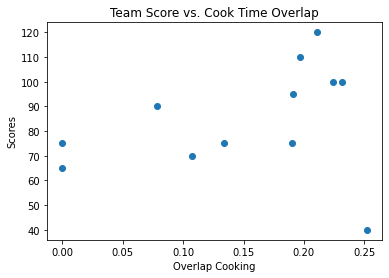

In [43]:
scores = [trial_data[t_id]['score'] for t_id in trial_data]
overlaps = [trial_data[t_id]['overlap_ratio'] for t_id in trial_data]
plt.scatter(overlaps, scores )
plt.xlabel("Overlap Cooking")
plt.ylabel("Scores")
plt.title("Team Score vs. Cook Time Overlap")
plt.show()


## 2. Utilization of counter space. Which objects are passed over which counters? Use of more than 1 counter? How is it distributed over other counters? Is it consistent in which object?

In [49]:
counter1 = (2,1)
counter2 = (2,2)
counter3 = (2,3)
counter4 = (1,0)
counter5 = (1,4)
counter6 = (4,2)
counter7 = (4,3)


loc_to_counter = {counter1:1, counter2:2, counter3:3,
                 counter4:4, counter5:5, counter6:6, counter7:7}



In [84]:
def compute_counter_utilization(p1_data, p2_data, objects_data, p1_actions, p2_actions, name):

    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)


    obj_count_id = 0
    next_obj_count_id = 0

    object_list_tracker = {}
    object_location_tracker = {}
    onion_counter_utilization = {1: {'items': [], 'n_uses':0},
                          2: {'items': [], 'n_uses':0},
                          3: {'items': [], 'n_uses':0},
                          4: {'items': [], 'n_uses':0},
                          5: {'items': [], 'n_uses':0},
                          6: {'items': [], 'n_uses':0},
                          7: {'items': [], 'n_uses':0}}
    dish_counter_utilization = {1: {'items': [], 'n_uses':0},
                          2: {'items': [], 'n_uses':0},
                          3: {'items': [], 'n_uses':0},
                          4: {'items': [], 'n_uses':0},
                          5: {'items': [], 'n_uses':0},
                          6: {'items': [], 'n_uses':0},
                          7: {'items': [], 'n_uses':0}}

    players_holding = {1: None, 2: None}

    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

    # loop over your images
    for a in range(len(t)-1):
    # for a in range(100):

        p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
        p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
        p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                    obj_p1(t, a, p1_data)[1], \
                    obj_p1(t, a, p1_data)[2]
        p1_act = action_p1(t, a, p1_actions)

        p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
        p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
        p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                    obj_p2(t, a, p2_data)[1], \
                    obj_p2(t, a, p2_data)[2]
        p2_act = action_p2(t, a, p2_actions)
        objects_list = world_obj(t, a, objects_data)

        # cook_state 
        # 0 = uncooked
        # 1 = cooking
        # 2 = cooked

        b = a+1
        p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
        p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
        p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                    obj_p1(t, b, p1_data)[1], \
                    obj_p1(t, b, p1_data)[2]
        p1_act_next = action_p1(t, b, p1_actions)

        p2_x_next, p2_y_next = f_p2(t, b, p2_data)[0], f_p2(t, b, p2_data)[1]
        p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
        p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                    obj_p2(t, b, p2_data)[1], \
                    obj_p2(t, b, p2_data)[2]
        p2_act_next = action_p2(t, a, p2_actions)
        objects_list_next = world_obj(t, b, objects_data)


        ################## PLAYER 1'S MOVEMENT ##################
        # If P1 moves or stays
        if p1_act in ['N', 'S', 'E', 'W']:
    #         print(p1_act, (p1_dir_x_next, p1_dir_y_next))
            if players_holding[1] is not None:
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_held_id = players_holding[1]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p1_time_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id
                
        # If P1 interacted
        if p1_act == 'I':
            # If P1 picked up an object
            if p1_obj_x is None and p1_obj_x_next is not None:
    #             print('p1 picked up object')
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_location_tracker[obj_location] = obj_count_id

                if obj_count_id not in object_list_tracker:
                    object_list_tracker[obj_count_id] = {}
                object_list_tracker[obj_count_id]['name'] = p1_obj_name_next
                object_list_tracker[obj_count_id]['player_holding'] = 1
                object_list_tracker[obj_count_id]['id'] = obj_count_id
                object_list_tracker[obj_count_id]['time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['p1_time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['p2_time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['location'] = obj_location
                object_list_tracker[obj_count_id]['on_screen'] = True

                players_holding[1] = obj_count_id

                obj_count_id += 1

            # If P1 put down an object
            if p1_obj_x is not None and p1_obj_x_next is None:
    #             print('p1 put down object')
                object_held_id = players_holding[1]

                object_list_tracker[object_held_id]['player_holding'] = 0
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p1_time_since_pickup'] += 1


                placed_obj_x, placed_obj_y = list(p1_x_next)[0]+p1_dir_x_next, list(p1_y_next)[0]+p1_dir_y_next
                old_obj_location = object_list_tracker[object_held_id]['location']
                new_obj_location = (placed_obj_x, placed_obj_y)
                object_list_tracker[object_held_id]['location'] = new_obj_location

                object_location_tracker.pop(old_obj_location, None)
                object_location_tracker[new_obj_location] = object_held_id

                players_holding[1] = None
                
                counter_number = loc_to_counter[new_obj_location]
                if object_list_tracker[object_held_id]['name'] == 'onion':
                    onion_counter_utilization[counter_number]['n_uses'] += 1
                    onion_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])
                if object_list_tracker[object_held_id]['name'] == 'dish':
                    dish_counter_utilization[counter_number]['n_uses'] += 1
                    dish_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])


        ################## PLAYER 2'S MOVEMENT ##################
        # If P2 moves or stays
        if p2_act in ['N', 'S', 'E', 'W']:
            if players_holding[2] is not None:
                obj_location = (p2_obj_x_next, p2_obj_y_next)
                object_held_id = players_holding[2]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p2_time_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id

        # If P2 interacted
        if p2_act == 'I':
            # If P2 picked up an object
            if p2_obj_x is None and p2_obj_x_next is not None:
                placed_x, placed_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next

                if (placed_x, placed_y) in object_location_tracker:
                    obj_picked_id = object_location_tracker[(placed_x, placed_y)]
                else:
                    print('problem p2 pickup not found')
                    nearest_key = min(list(object_location_tracker.keys()), key=lambda c: (c[0]- placed_x)**2 + (c[1]-placed_y)**2)
                    obj_picked_id = object_location_tracker[nearest_key]
                    
                new_obj_location = (p2_obj_x_next, p2_obj_y_next)


                object_list_tracker[obj_picked_id]['player_holding'] = 2
                object_list_tracker[obj_picked_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p2_time_since_pickup'] += 1
                object_list_tracker[obj_picked_id]['location'] = new_obj_location
                object_list_tracker[obj_picked_id]['on_screen'] = True

                players_holding[2] = obj_picked_id

                object_location_tracker.pop((placed_x, placed_y), None)
                object_location_tracker[new_obj_location] = obj_picked_id


        # If P2 put down an object
        if p2_obj_x is not None and p2_obj_x_next is None:
    #         print('p2 put down object')
            object_held_id = players_holding[2]

            object_list_tracker[object_held_id]['player_holding'] = 0
            object_list_tracker[object_held_id]['time_since_pickup'] += 1
            object_list_tracker[object_held_id]['p2_time_since_pickup'] += 1


            placed_obj_x, placed_obj_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next
            old_obj_location = object_list_tracker[object_held_id]['location']
            new_obj_location = (placed_obj_x, placed_obj_y)
            object_list_tracker[object_held_id]['location'] = new_obj_location

            object_location_tracker.pop(old_obj_location, None)
            object_location_tracker[new_obj_location] = object_held_id


            players_holding[2] = None
            
            if new_obj_location in loc_to_counter:
                counter_number = loc_to_counter[new_obj_location]
                if object_list_tracker[object_held_id]['name'] == 'onion':
                    onion_counter_utilization[counter_number]['n_uses'] += 1
                    onion_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])
                if object_list_tracker[object_held_id]['name'] == 'dish':
                    dish_counter_utilization[counter_number]['n_uses'] += 1
                    dish_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])




    #     print('object_list_tracker', object_list_tracker)
#         print('object_location_tracker', object_location_tracker)
#         print('players_holding', players_holding)
#         print()
    return onion_counter_utilization, dish_counter_utilization


In [85]:
layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'
trial_data = {}

for j in range(len(layout_trials)):
# for j in [1]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
#         print('joint_actions', joint_actions)
        
        if state_x['players'][0]['position'][0] == 1:
            p1_index = 0
            p2_index = 1
        else:
            p1_index = 1
            p2_index = 0
        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
#         break
        
    trial_data[trial_id] = {}
    trial_data[trial_id]['p1_length'] = len(p1_data)
    trial_data[trial_id]['p2_length'] = len(p2_data)
    
    trial_data[trial_id]['score'] = score
    
    onion_counter_utilization, dish_counter_utilization = compute_counter_utilization(p1_data, 
                                    p2_data,
                                   objects_data,
                                   p1_actions,
                                   p2_actions,
                                   name)

    trial_data[trial_id]['onion_counter_use'] = onion_counter_utilization
    trial_data[trial_id]['dish_counter_use'] = dish_counter_utilization
    
    

trial_id 9
trial_id 14
trial_id 19
trial_id 24
trial_id 54
trial_id 59
problem p2 pickup not found
problem p2 pickup not found
trial_id 64
trial_id 69
trial_id 79
trial_id 89
trial_id 99
trial_id 114


In [86]:
trial_data[trial_id]['']

scores = [trial_data[t_id]['score'] for t_id in trial_data]
overlaps = [trial_data[t_id]['counter_use'] for t_id in trial_data]
plt.scatter(overlaps, scores )
plt.xlabel("Overlap Cooking")
plt.ylabel("Scores")
plt.title("Team Score vs. Cook Time Overlap")
plt.show()


KeyError: ''

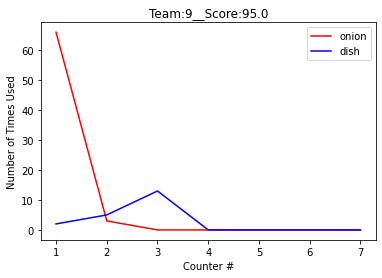

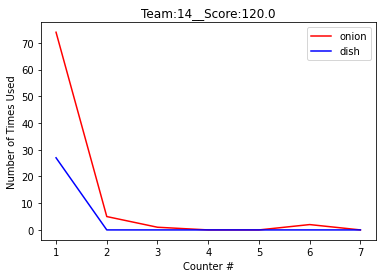

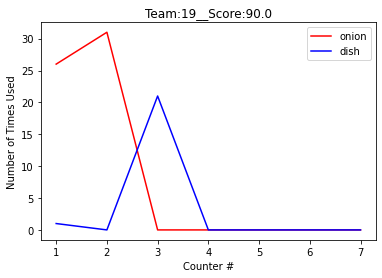

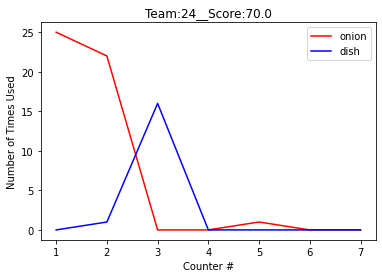

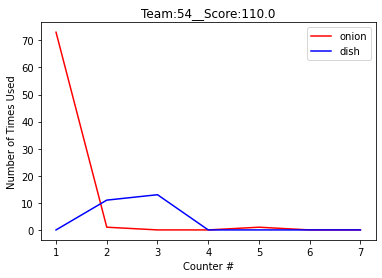

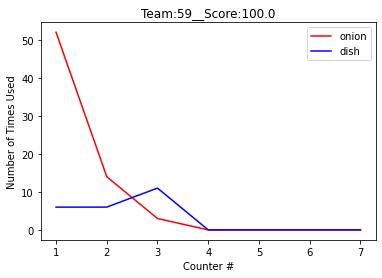

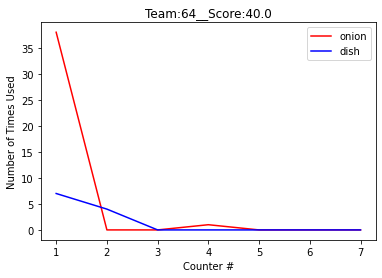

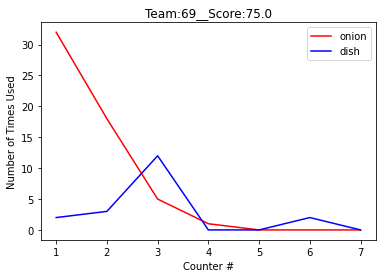

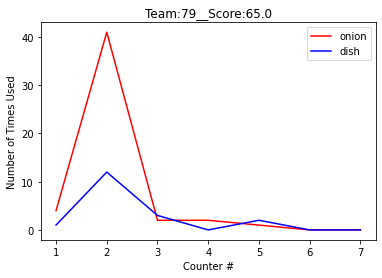

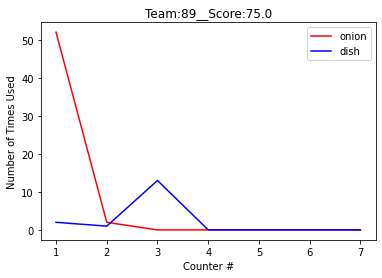

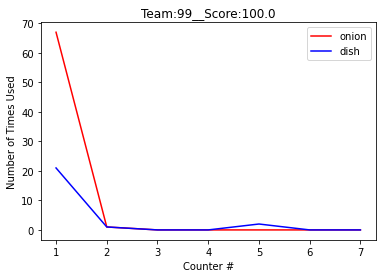

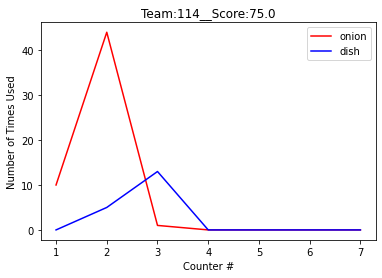

In [87]:
for t_id in trial_data:
    score = trial_data[t_id]['score']
    onion_counter_usage = trial_data[t_id]['onion_counter_use']
    onion_dist_usage = [onion_counter_usage[c]['n_uses'] for c in onion_counter_usage]
    plt.plot(counter_usage.keys(), onion_dist_usage, color='r')
    
    dish_counter_usage = trial_data[t_id]['dish_counter_use']
    dish_dist_usage = [dish_counter_usage[c]['n_uses'] for c in dish_counter_usage]
    plt.plot(counter_usage.keys(), dish_dist_usage, color='b')
    
    plt.title("Team:"+str(t_id)+'__Score:'+str(score))
    plt.legend(['onion', 'dish'])
    plt.xlabel("Counter #")
    plt.ylabel("Number of Times Used")
    plt.show()
    plt.close()
# plt.scatter(overlaps, scores )
# plt.xlabel("Overlap Cooking")
# plt.ylabel("Scores")
# plt.title("Team Score vs. Cook Time Overlap")
# plt.show()


# 3. How does counter strategy change over time?

In [78]:
def compute_counter_over_time(p1_data, p2_data, objects_data, p1_actions, p2_actions, name, time_elapsed):

    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)


    obj_count_id = 0
    next_obj_count_id = 0

    object_list_tracker = {}
    object_location_tracker = {}
    onion_counter_utilization = {1: {'items': [], 'n_uses':0},
                          2: {'items': [], 'n_uses':0},
                          3: {'items': [], 'n_uses':0},
                          4: {'items': [], 'n_uses':0},
                          5: {'items': [], 'n_uses':0},
                          6: {'items': [], 'n_uses':0},
                          7: {'items': [], 'n_uses':0}}
    dish_counter_utilization = {1: {'items': [], 'n_uses':0},
                          2: {'items': [], 'n_uses':0},
                          3: {'items': [], 'n_uses':0},
                          4: {'items': [], 'n_uses':0},
                          5: {'items': [], 'n_uses':0},
                          6: {'items': [], 'n_uses':0},
                          7: {'items': [], 'n_uses':0}}
    
    # (timestamp, counter_num)
    onion_time_counter = []
    dish_time_counter = []

    players_holding = {1: None, 2: None}

    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

    # loop over your images
    for a in range(len(t)-1):
    # for a in range(100):

        p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
        p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
        p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                    obj_p1(t, a, p1_data)[1], \
                    obj_p1(t, a, p1_data)[2]
        p1_act = action_p1(t, a, p1_actions)

        p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
        p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
        p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                    obj_p2(t, a, p2_data)[1], \
                    obj_p2(t, a, p2_data)[2]
        p2_act = action_p2(t, a, p2_actions)
        objects_list = world_obj(t, a, objects_data)
        timestamp = time_elapsed[a]

        # cook_state 
        # 0 = uncooked
        # 1 = cooking
        # 2 = cooked

        b = a+1
        p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
        p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
        p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                    obj_p1(t, b, p1_data)[1], \
                    obj_p1(t, b, p1_data)[2]
        p1_act_next = action_p1(t, b, p1_actions)

        p2_x_next, p2_y_next = f_p2(t, b, p2_data)[0], f_p2(t, b, p2_data)[1]
        p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
        p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                    obj_p2(t, b, p2_data)[1], \
                    obj_p2(t, b, p2_data)[2]
        p2_act_next = action_p2(t, a, p2_actions)
        objects_list_next = world_obj(t, b, objects_data)


        ################## PLAYER 1'S MOVEMENT ##################
        # If P1 moves or stays
        if p1_act in ['N', 'S', 'E', 'W']:
    #         print(p1_act, (p1_dir_x_next, p1_dir_y_next))
            if players_holding[1] is not None:
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_held_id = players_holding[1]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p1_time_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id
                
        # If P1 interacted
        if p1_act == 'I':
            # If P1 picked up an object
            if p1_obj_x is None and p1_obj_x_next is not None:
    #             print('p1 picked up object')
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_location_tracker[obj_location] = obj_count_id

                if obj_count_id not in object_list_tracker:
                    object_list_tracker[obj_count_id] = {}
                object_list_tracker[obj_count_id]['name'] = p1_obj_name_next
                object_list_tracker[obj_count_id]['player_holding'] = 1
                object_list_tracker[obj_count_id]['id'] = obj_count_id
                object_list_tracker[obj_count_id]['time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['p1_time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['p2_time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['location'] = obj_location
                object_list_tracker[obj_count_id]['on_screen'] = True

                players_holding[1] = obj_count_id

                obj_count_id += 1

            # If P1 put down an object
            if p1_obj_x is not None and p1_obj_x_next is None:
    #             print('p1 put down object')
                object_held_id = players_holding[1]

                object_list_tracker[object_held_id]['player_holding'] = 0
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p1_time_since_pickup'] += 1


                placed_obj_x, placed_obj_y = list(p1_x_next)[0]+p1_dir_x_next, list(p1_y_next)[0]+p1_dir_y_next
                old_obj_location = object_list_tracker[object_held_id]['location']
                new_obj_location = (placed_obj_x, placed_obj_y)
                object_list_tracker[object_held_id]['location'] = new_obj_location

                object_location_tracker.pop(old_obj_location, None)
                object_location_tracker[new_obj_location] = object_held_id

                players_holding[1] = None
                
                counter_number = loc_to_counter[new_obj_location]
                if counter_number in [1,2,3]:
                    if object_list_tracker[object_held_id]['name'] == 'onion':
                        onion_counter_utilization[counter_number]['n_uses'] += 1
                        onion_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])
                        onion_time_counter.append((timestamp, counter_number))
                    if object_list_tracker[object_held_id]['name'] == 'dish':
                        dish_counter_utilization[counter_number]['n_uses'] += 1
                        dish_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])
                        dish_time_counter.append((timestamp, counter_number))

        ################## PLAYER 2'S MOVEMENT ##################
        # If P2 moves or stays
        if p2_act in ['N', 'S', 'E', 'W']:
            if players_holding[2] is not None:
                obj_location = (p2_obj_x_next, p2_obj_y_next)
                object_held_id = players_holding[2]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p2_time_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id

        # If P2 interacted
        if p2_act == 'I':
            # If P2 picked up an object
            if p2_obj_x is None and p2_obj_x_next is not None:
                placed_x, placed_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next

                if (placed_x, placed_y) in object_location_tracker:
                    obj_picked_id = object_location_tracker[(placed_x, placed_y)]
                else:
                    print('problem p2 pickup not found')
                    nearest_key = min(list(object_location_tracker.keys()), key=lambda c: (c[0]- placed_x)**2 + (c[1]-placed_y)**2)
                    obj_picked_id = object_location_tracker[nearest_key]
                    
                new_obj_location = (p2_obj_x_next, p2_obj_y_next)


                object_list_tracker[obj_picked_id]['player_holding'] = 2
                object_list_tracker[obj_picked_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['p2_time_since_pickup'] += 1
                object_list_tracker[obj_picked_id]['location'] = new_obj_location
                object_list_tracker[obj_picked_id]['on_screen'] = True

                players_holding[2] = obj_picked_id

                object_location_tracker.pop((placed_x, placed_y), None)
                object_location_tracker[new_obj_location] = obj_picked_id


        # If P2 put down an object
        if p2_obj_x is not None and p2_obj_x_next is None:
    #         print('p2 put down object')
            object_held_id = players_holding[2]

            object_list_tracker[object_held_id]['player_holding'] = 0
            object_list_tracker[object_held_id]['time_since_pickup'] += 1
            object_list_tracker[object_held_id]['p2_time_since_pickup'] += 1


            placed_obj_x, placed_obj_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next
            old_obj_location = object_list_tracker[object_held_id]['location']
            new_obj_location = (placed_obj_x, placed_obj_y)
            object_list_tracker[object_held_id]['location'] = new_obj_location

            object_location_tracker.pop(old_obj_location, None)
            object_location_tracker[new_obj_location] = object_held_id


            players_holding[2] = None
            
            if new_obj_location in loc_to_counter:
                counter_number = loc_to_counter[new_obj_location]
                if counter_number in [1,2,3]:
                    if object_list_tracker[object_held_id]['name'] == 'onion':
                        onion_counter_utilization[counter_number]['n_uses'] += 1
                        onion_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])
                        onion_time_counter.append((timestamp, counter_number))
                    if object_list_tracker[object_held_id]['name'] == 'dish':
                        dish_counter_utilization[counter_number]['n_uses'] += 1
                        dish_counter_utilization[counter_number]['items'].append(object_list_tracker[object_held_id]['name'])
                        dish_time_counter.append((timestamp, counter_number))



    #     print('object_list_tracker', object_list_tracker)
#         print('object_location_tracker', object_location_tracker)
#         print('players_holding', players_holding)
#         print()
    return onion_time_counter, dish_time_counter


In [89]:
layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'
trial_data = {}

for j in range(len(layout_trials)):
# for j in [1]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    time_elapsed = trial_df['time_elapsed'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
#         print('joint_actions', joint_actions)
        
        if state_x['players'][0]['position'][0] == 1:
            p1_index = 0
            p2_index = 1
        else:
            p1_index = 1
            p2_index = 0
        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
#         break
        
    trial_data[trial_id] = {}
    trial_data[trial_id]['p1_length'] = len(p1_data)
    trial_data[trial_id]['p2_length'] = len(p2_data)
    
    trial_data[trial_id]['score'] = score
    
    onion_counter_utilization, dish_counter_utilization = compute_counter_over_time(p1_data, 
                                    p2_data,
                                   objects_data,
                                   p1_actions,
                                   p2_actions,
                                   name, time_elapsed)

    trial_data[trial_id]['onion_counter_use'] = onion_counter_utilization
    trial_data[trial_id]['dish_counter_use'] = dish_counter_utilization
    
    

trial_id 9
trial_id 14
trial_id 19
trial_id 24
trial_id 54
trial_id 59
problem p2 pickup not found
problem p2 pickup not found
trial_id 64
trial_id 69
trial_id 79
trial_id 89
trial_id 99
trial_id 114


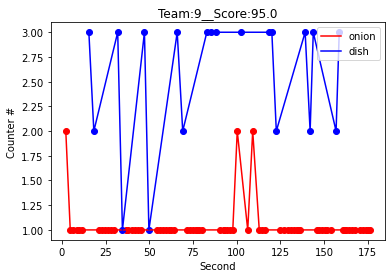

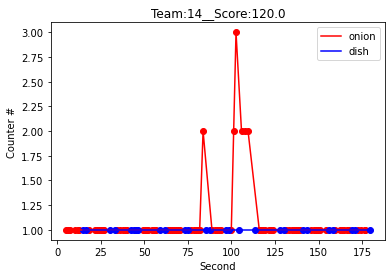

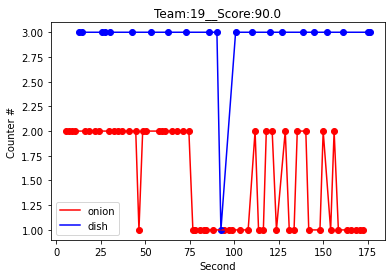

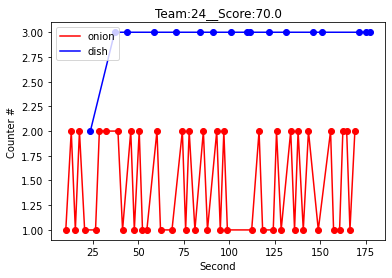

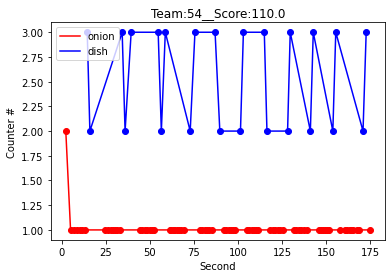

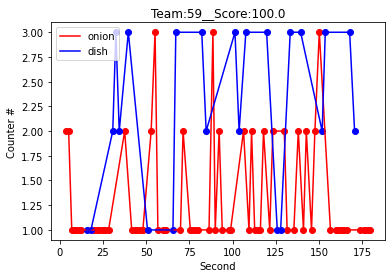

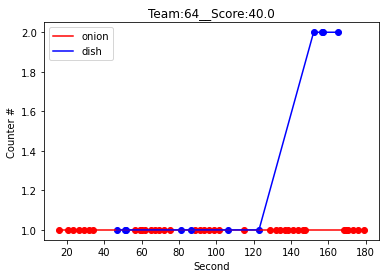

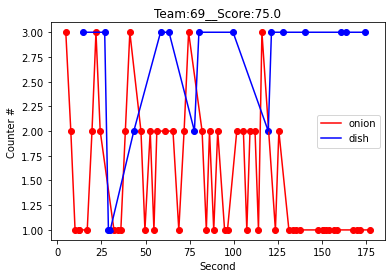

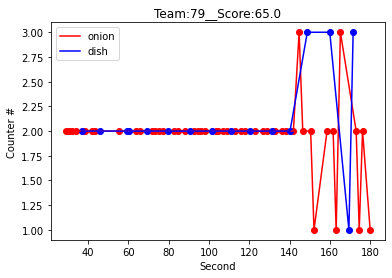

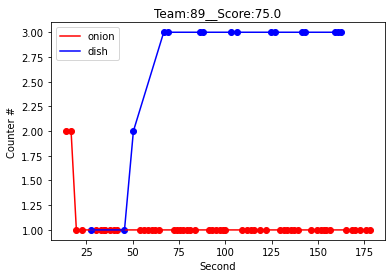

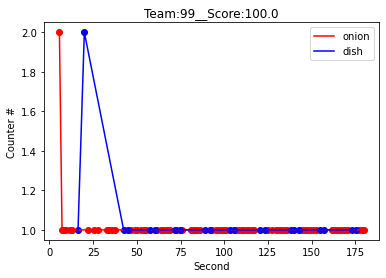

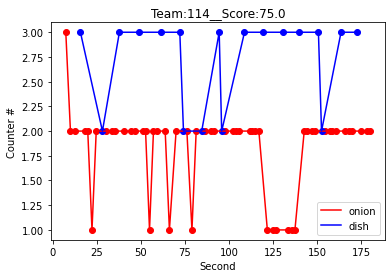

In [90]:
for t_id in trial_data:
    score = trial_data[t_id]['score']
    
    onion_timestamps = [elem[0] for elem in trial_data[t_id]['onion_counter_use']]
    onion_cnum_used = [elem[1] for elem in trial_data[t_id]['onion_counter_use']]
    dish_timestamps = [elem[0] for elem in trial_data[t_id]['dish_counter_use']]
    dish_cnum_used = [elem[1] for elem in trial_data[t_id]['dish_counter_use']]
    
    
    plt.scatter(onion_timestamps, onion_cnum_used, color='r')
    plt.plot(onion_timestamps, onion_cnum_used, color='r')
    

    plt.scatter(dish_timestamps, dish_cnum_used, color='b')
    plt.plot(dish_timestamps, dish_cnum_used, color='b')
    
    plt.title("Team:"+str(t_id)+'__Score:'+str(score))
    plt.legend(['onion', 'dish'])
    plt.xlabel("Second")
    plt.ylabel("Counter #")
    plt.show()
    plt.close()
# plt.scatter(overlaps, scores )
# plt.xlabel("Overlap Cooking")
# plt.ylabel("Scores")
# plt.title("Team Score vs. Cook Time Overlap")
# plt.show()


# Consistency of Strategy